### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
np.random.seed(306)

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Creates 10 folds keeping aside 20% samples as test **in each fold**.

# STEP 1: Loading Dataset

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

In [5]:
print("Shape of feature matrix: ", features.shape)
print("Shape of label vector: ", labels.shape)

Shape of feature matrix:  (20640, 8)
Shape of label vector:  (20640,)


# STEP 2: Data Exploration

# STEP 3: Preprocessing and Model Building

### Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

### Pipeline + Model

In [7]:
lin_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('lin_reg', LinearRegression())
])

# train linear regression model with normal equation
lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [8]:
print(lin_reg_pipeline)
print('Intercept w_0: ', lin_reg_pipeline[-1].intercept_)
print('Weights w_1....w_m: ', lin_reg_pipeline[-1].coef_)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])
Intercept w_0:  2.0703489205426377
Weights w_1....w_m:  [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


# STEP 4: Model Evaluation

### `score`
- Comparison of errors for model diagnostic purpose (over/under/right fit)

In [9]:
train_score = lin_reg_pipeline.score(train_features, train_labels)
print('Model performance on train set: ', train_score)

test_score = lin_reg_pipeline.score(test_features, test_labels)
print('Model performance on test set: ', test_score)

Model performance on train set:  0.609873031052925
Model performance on test set:  0.5910509795491351


- `score` method returns the `r2` score whose best value is 1.
- Both `r2` scores are compatible but not that high.
- It points to under fitting issue in model training.

### `cross_val_score`

In [10]:
lin_reg_score = cross_val_score(
    lin_reg_pipeline,
    train_features, 
    train_labels,
    scoring='neg_mean_squared_error',
    cv=shuffle_split_cv
)

# This will return 10 different scores, one for each fold
print(lin_reg_score)

# We can take the mean and standard deviation to report it
print(f'\nScore for linear regression model on test set:\n\
      {lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}')

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score for linear regression model on test set:
      -0.529 +/- 0.022


In [11]:
lin_reg_mse = -lin_reg_score
print(f'MSE of linear regression mode is: \n\
      {lin_reg_mse.mean():.3f} +/- {lin_reg_mse.std():.3f}')

MSE of linear regression mode is: 
      0.529 +/- 0.022


### `cross_validate`

In [12]:
lin_reg_cv_results = cross_validate(
    lin_reg_pipeline,
    train_features,
    train_labels,
    cv=shuffle_split_cv,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    return_estimator=True
)

In [13]:
lin_reg_cv_results

{'fit_time': array([0.00745893, 0.01319671, 0.01253581, 0.01219034, 0.01438165,
        0.01465583, 0.01405215, 0.01214767, 0.01094818, 0.01069999]),
 'score_time': array([0.        , 0.00370121, 0.00399923, 0.00430846, 0.00525761,
        0.00399685, 0.00401592, 0.00353909, 0.00320244, 0.00240016]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

In [16]:
train_error = -1 * lin_reg_cv_results['train_score']
print(f'MSE on train set: {train_error.mean():.3f}')

test_error = -1 * lin_reg_cv_results['test_score']
print(f'MSE on test set: {test_error.mean():.3f}')

MSE on train set: 0.519
MSE on test set: 0.529


### Effect of Training Set Size on Error
*Code included plotting the **learning curve** but this was not so clear in the video*

### Model Examination
- Let's examine weight vector and how much variability exists between them
  across different cross-validation results.

In [19]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [21]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results['estimator']]
weights_df = pd.DataFrame(coefs, columns=feature_names)

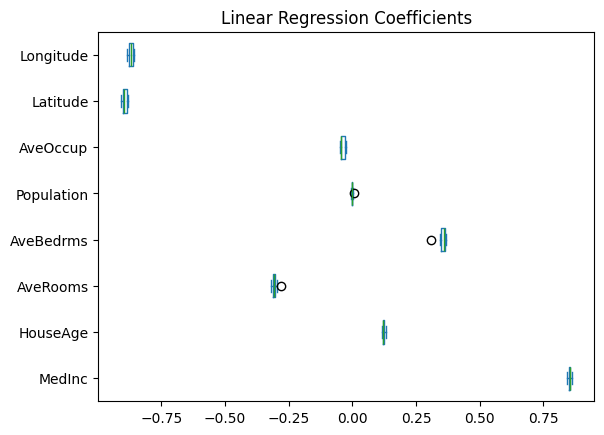

In [22]:
weights_df.plot.box(vert=False)
_ = plt.title("Linear Regression Coefficients")

### Selecting **Best Model**

In [24]:
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

### Model Performance

In [26]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(lin_reg_pipeline,train_features, train_labels)

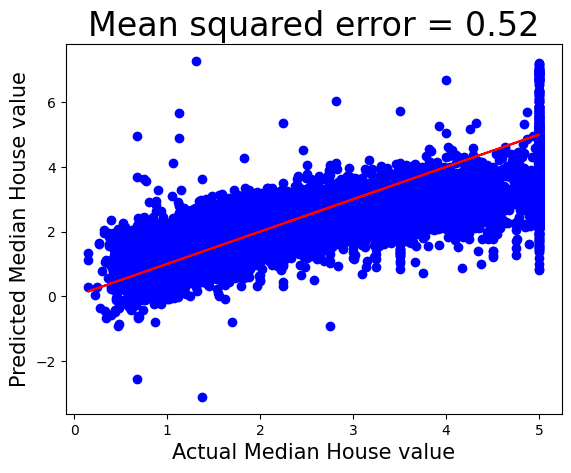

In [28]:
mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')
plt.title(f"Mean squared error = {mse_cv :.2f}", size=24)
plt.xlabel ('Actual Median House value', size=15)
plt.ylabel ('Predicted Median House value', size=15)
plt.show()

- Model seems to make predictions all over the place.
- Some predictions are negative, we need to put some constraints on weights.

# STEP 5: Predictions

We can use the best performing model to make predictions.

In [29]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

predicting using the initial model built without cross validation.

In [30]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

# STEP 6: Report Model Performance

In [31]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print(f'R2 score for the best model with cv: {score_cv}')
print(f'R2 score for the model without cv: {score}')

R2 score for the best model with cv: 0.5923577635319087
R2 score for the model without cv: 0.5910509795491351
